## Imports

In [5]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Settings and Dataset

In [6]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 123
learning_rate = 0.01
num_epochs = 10
batch_size = 128

# Architecture
num_classes = 10


##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## ResNet with identity blocks

In [7]:
##########################
### MODEL
##########################



class ConvNet(torch.nn.Module):

    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        
        #########################
        ### 1st residual block
        #########################
        # 28x28x1 => 28x28x4
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=4,
                                      kernel_size=(1, 1),
                                      stride=(1, 1),
                                      padding=0)
        self.conv_1_bn = torch.nn.BatchNorm2d(4)
                                    
        # 28x28x4 => 28x28x1
        self.conv_2 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=1,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1)   
        self.conv_2_bn = torch.nn.BatchNorm2d(1)
        
        
        #########################
        ### 2nd residual block
        #########################
        # 28x28x1 => 28x28x4
        self.conv_3 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=4,
                                      kernel_size=(1, 1),
                                      stride=(1, 1),
                                      padding=0)
        self.conv_3_bn = torch.nn.BatchNorm2d(4)
      
        # 28x28x4 => 28x28x1
        self.conv_4 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=1,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1)   
        self.conv_4_bn = torch.nn.BatchNorm2d(1)

        #########################
        ### Fully connected
        #########################        
        self.linear_1 = torch.nn.Linear(28*28*1, num_classes)

    def forward(self, x):
        
        #########################
        ### 1st residual block
        #########################
        shortcut = x
        
        out = self.conv_1(x)
        out = self.conv_1_bn(out)
        out = F.relu(out)

        out = self.conv_2(out)
        out = self.conv_2_bn(out)
        
        out += shortcut
        out = F.relu(out)
        
        #########################
        ### 2nd residual block
        #########################
        
        shortcut = out
        
        out = self.conv_3(out)
        out = self.conv_3_bn(out)
        out = F.relu(out)

        out = self.conv_4(out)
        out = self.conv_4_bn(out)
        
        out += shortcut
        out = F.relu(out)
        
        #########################
        ### Fully connected
        #########################   
        logits = self.linear_1(out.view(-1, 28*28*1))
        probas = F.softmax(logits, dim=1)
        return logits, probas
    
torch.manual_seed(random_seed)
model = ConvNet(num_classes=num_classes)
model = model.to(device)
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

### Training

In [ ]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):            
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

start_time = time.time()
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)
        
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))

    model = model.eval() # eval mode to prevent upd. batchnorm params during inference
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader)))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

In [41]:
from PIL import Image
from torchvision import transforms

# Open an image using PIL


def inference(input_image):
    preprocess = transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(),
        transforms.ToTensor()
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    with torch.no_grad():
        output = model(input_batch)
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    probabilities = output[1]
    print(probabilities)
    
    # Read the categories
    # with open("imagenet_classes.txt", "r") as f:
    #     categories = [s.strip() for s in f.readlines()]
    # Show top categories per image
    categories = [0,1,2,3,4,5,6,7,8,9]
    prob, catid = torch.topk(probabilities, 1)
    result = {"label":categories[catid],"probability":prob[0][0]}
    
    # for i in range(prob.size(0)):
    #     result[categories[catid[i]]] = prob[i].item()
    return result



In [55]:
image = Image.open("data/images/5.png")
# print(inference(image))

# sample_image, sample_label = test_dataset[2000]

# # Print the shape of the sample image
# print("Shape of the sample image:", sample_image.shape)

# # Print the label of the sample image
# print("Label of the sample image:", sample_label)

# plt.imshow(sample_image[0], cmap='gray')
# plt.show()

# to_pil_img = transforms.ToPILImage()
# img = to_pil_img(sample_image)
# inference(img)

# Define the transform
resize_transform = transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(),
        transforms.RandomInvert(1)
    ])

# Apply the transform to the image
resized_image = resize_transform(image)
print(inference(resized_image))
resized_image

tensor([[7.2849e-04, 2.1798e-06, 3.8219e-03, 1.4613e-02, 3.0687e-04, 9.7193e-01,
         7.3067e-03, 4.4243e-08, 1.2411e-03, 4.9757e-05]])
{'label': 5, 'probability': tensor(0.9719)}


In [118]:
correct_pred, num_examples = 0, 0
true_lables, pred_labels = [],[]

for i, (features, targets) in enumerate(train_loader):            
    features = features.to(device)
    targets = targets.to(device)
    logits, probas = model(features)

    _, predicted_labels = torch.max(probas, 1)
    num_examples += targets.size(0)
    correct_pred += (predicted_labels == targets).sum()
print(correct_pred,num_examples)
print(correct_pred.float()/num_examples * 100)


tensor(56265) 60000
tensor(93.7750)


tensor(93.7750) 0.9371742416130451


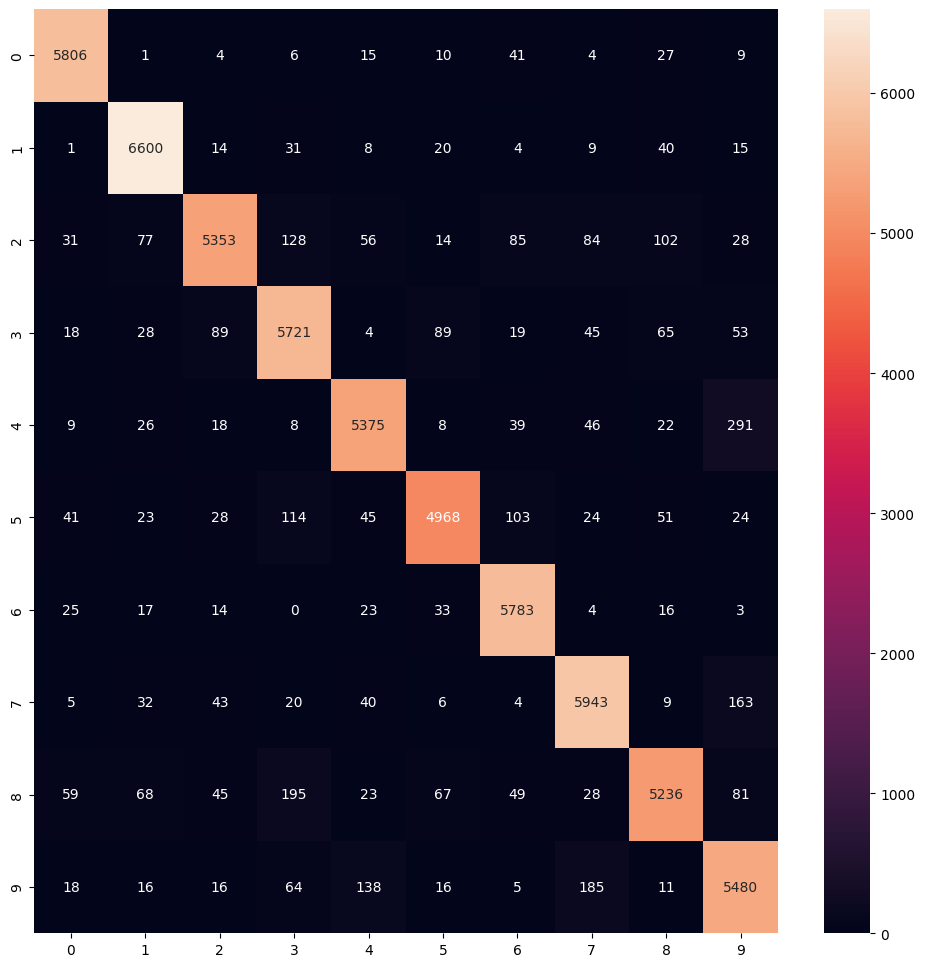

In [56]:
import seaborn as sns
from sklearn.metrics import f1_score

def compute_accuracy_and_cm(model, data_loader):
    correct_pred, num_examples = 0, 0
    true_labels, pred_labels = [], []
    for i, (features, targets) in enumerate(data_loader):            
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        true_labels.append(targets.cpu().numpy())
        pred_labels.append(predicted_labels.cpu().numpy())
    true_labels = np.concatenate(true_labels)
    pred_labels = np.concatenate(pred_labels)
    cm = confusion_matrix(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average='macro')
    return correct_pred, num_examples, correct_pred.float()/num_examples * 100, cm, f1

a,b,accuracy,cm, f1 = compute_accuracy_and_cm(model,train_loader)

print(accuracy,f1)
class_types = [0,1,2,3,4,5,6,7,8,9]

plt.figure(figsize=(12,12))
sns_hmp = sns.heatmap(cm, annot=True, xticklabels = class_types, 
            yticklabels = class_types, fmt="d")
fig = sns_hmp.get_figure()